## First generate an image with Flux Schnell

In [1]:
import torch
from diffusers import FluxPipeline
from diffusers.utils import load_image
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from utils import preprocess_image,pil_to_cv2,cv2_to_pil, show_image_cv2, clear_gpu_memory
import copy
from diffusion_utils import load_pipeline,generate_outpaint,fix_mask, fix_inpaint_mask, vis_inpaint_strategy,composite_with_mask, load_contolnet_pipeline,outpaint_controlnet
import torch
from dust3r_infer import get_focals
from image_utils import *
import copy

GEN = False
USE_SDXL = False

IMAGE_SIZE = 1024
if GEN == True:
	pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
	pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power
	prompt = "a town square in a city with a person standing in the center"
	image = pipe(
		prompt,
		guidance_scale=0.0,
		num_inference_steps=4,
		max_sequence_length=256,
		generator=torch.Generator("cpu").manual_seed(0)
	).images[0]
	image.save("middle.jpg")
	clear_gpu_memory()
	focals = get_focals('middle.jpg', 512)
	source_image_cv2 = pil_to_cv2(image)
	show_image_cv2(source_image_cv2)



Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/cedric/PanoramaGenInpaint/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Use Dust3R to estimate the FOV and map it to the equirectangular image

In [2]:
if GEN : 
	h_fov = focal_to_fov(focals[0], 512)  # Assuming 512 is your reference dimension
	print(f"Horizontal FOV: {h_fov} degrees")
	equirectangular_image,non_wrapped = image_to_equirectangular(source_image_cv2, h_fov, 2028*4,1024*4,wrap_around=True)
	cv2_to_pil(equirectangular_image).save("imgs/initial_pano_with_back.png")
	cv2_to_pil(non_wrapped).save("imgs/initial_pano_center.png")
	show_image_cv2(equirectangular_image)

## Visualisation of rough inpainting regions

/home/cedric/PanoramaGenInpaint/image_utils.py:362: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_x = world_x / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_y = world_y / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: invalid value encountered in divide
  persp_ndc_y = world_y / world_z


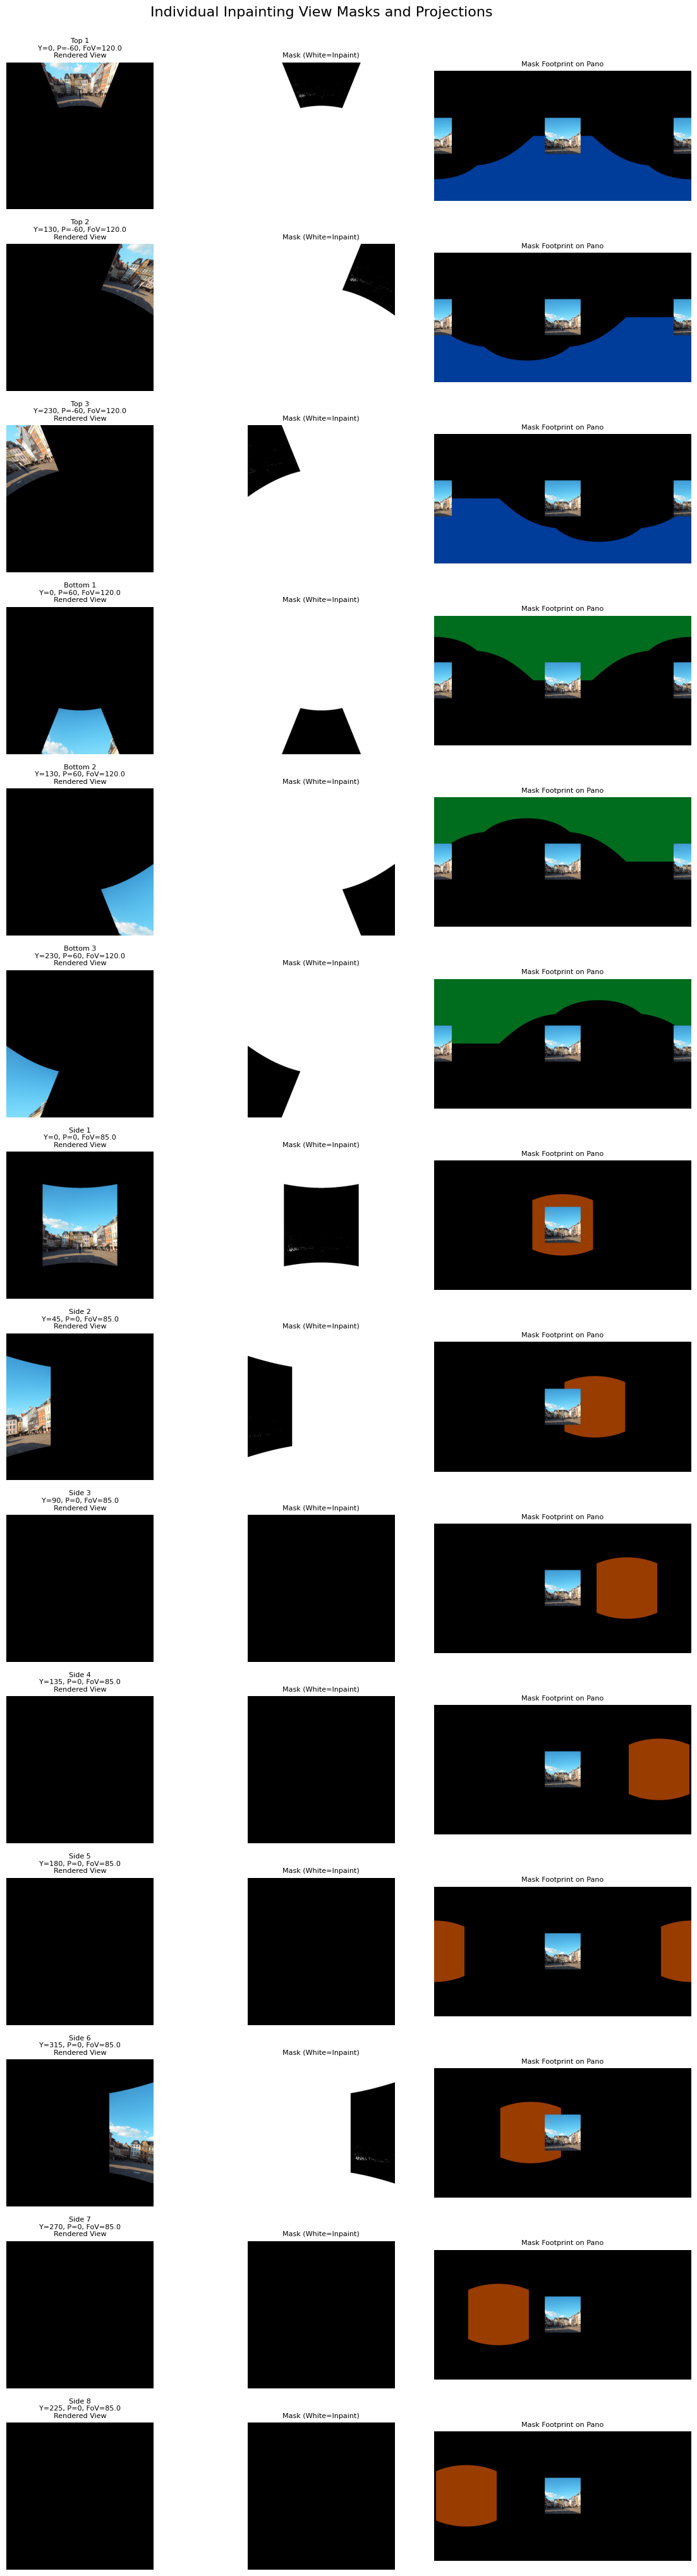

In [3]:
all_views_data = vis_inpaint_strategy()

In [4]:

def load_contolnet_pipeline():
	import sys 
	sys.path.append('/home/cedric/PanoramaGenInpaint/FLUX-Controlnet-Inpainting')
	from diffusers.utils import load_image, check_min_version
	from controlnet_flux import FluxControlNetModel
	from transformer_flux import FluxTransformer2DModel
	from pipeline_flux_controlnet_inpaint import FluxControlNetInpaintingPipeline
	from torchao.quantization import quantize_, int8_weight_only

	controlnet = FluxControlNetModel.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha", torch_dtype=torch.bfloat16)
	transformer = FluxTransformer2DModel.from_pretrained(
			"black-forest-labs/FLUX.1-dev", subfolder='transformer', torch_dtype=torch.bfloat16)
	
	quantize_(transformer, int8_weight_only())
	quantize_(controlnet, int8_weight_only())

	pipe = FluxControlNetInpaintingPipeline.from_pretrained(
		"black-forest-labs/FLUX.1-dev",
		controlnet=controlnet,
		transformer=transformer,
		torch_dtype=torch.bfloat16
	)
	pipe.enable_model_cpu_offload()
	pipe.transformer.to(torch.bfloat16)
	pipe.controlnet.to(torch.bfloat16)
	return pipe 



## Approach C)  

In [5]:
def fix_inpaint_mask(mask, contour_color=(0, 255, 0), fill_color=(0, 0, 0),extend_amount=100,add_boarder_mode=None):
    mask_copy = mask.copy()
    if mask_copy.dtype != np.uint8:
    
        mask_copy = (mask_copy * 255).astype(np.uint8)
    
    
    inverted = cv2.bitwise_not(mask_copy)
    contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(mask_copy, contours, -1, 0 , -1)
    # Now extend the mask into black regions
    if extend_amount > 0:
        kernel = np.ones((extend_amount, extend_amount), np.uint8)
        mask_copy = cv2.dilate(mask_copy, kernel, iterations=1)
        
    blur_amount = 20
    if blur_amount > 0:
        mask_copy = cv2.GaussianBlur(mask_copy, (blur_amount*2+1, blur_amount*2+1), 0)
        # Normalize back to proper range
    print(mask_copy.shape)
    if add_boarder_mode == 'r1':
        mask_copy[:,-300:] = 0
    elif add_boarder_mode == 'r2':
        mask_copy = np.zeros_like(mask_copy)
        mask_copy[:,-350:] = 255
    return mask_copy

## Perform iterative Inpainting (First Top and Bottom views)

GPU memory cleared


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

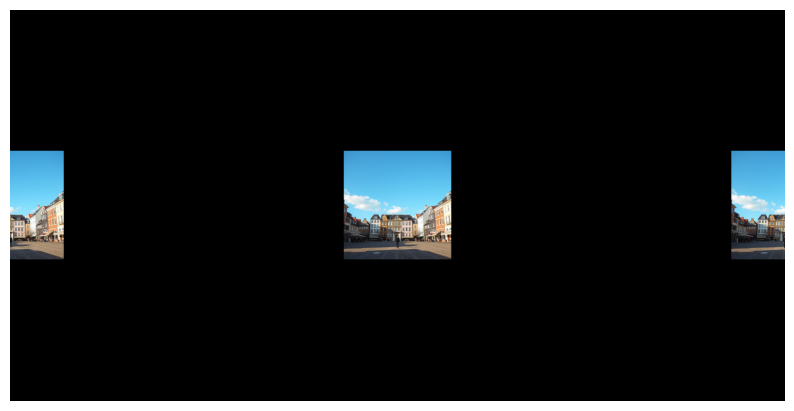

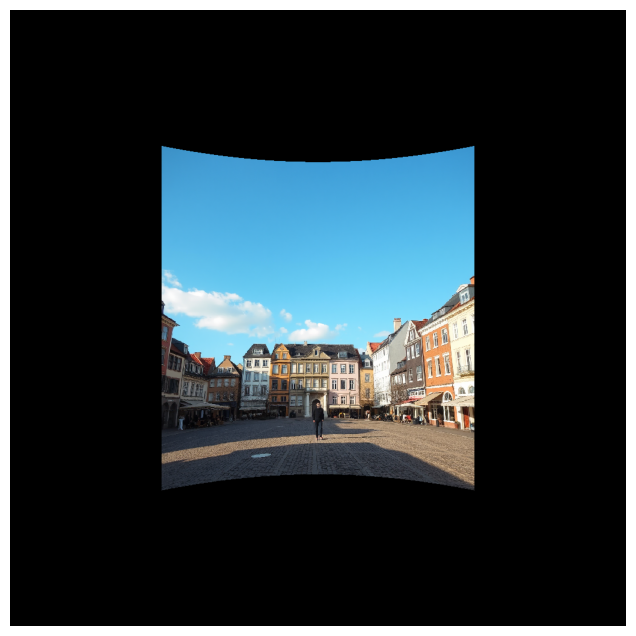

(1024, 1024)


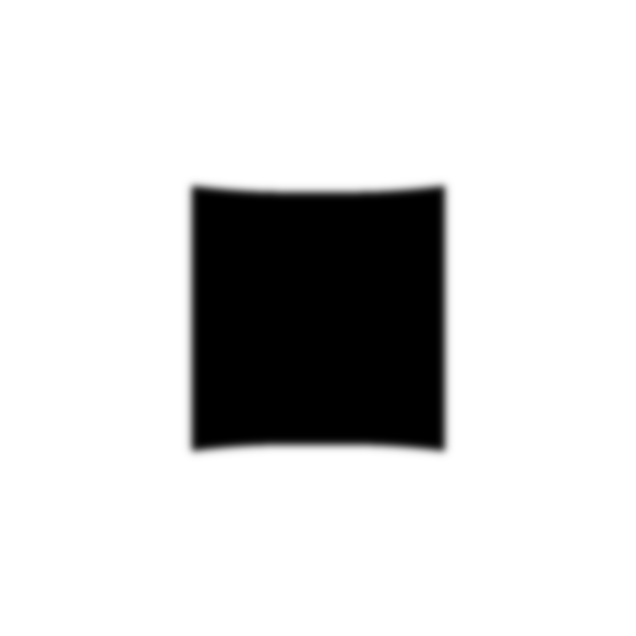

Render image shape: (1024, 1024)(1024, 1024)
Check inputs
Start denoise


  0%|          | 0/30 [00:00<?, ?it/s]

Inpainting done


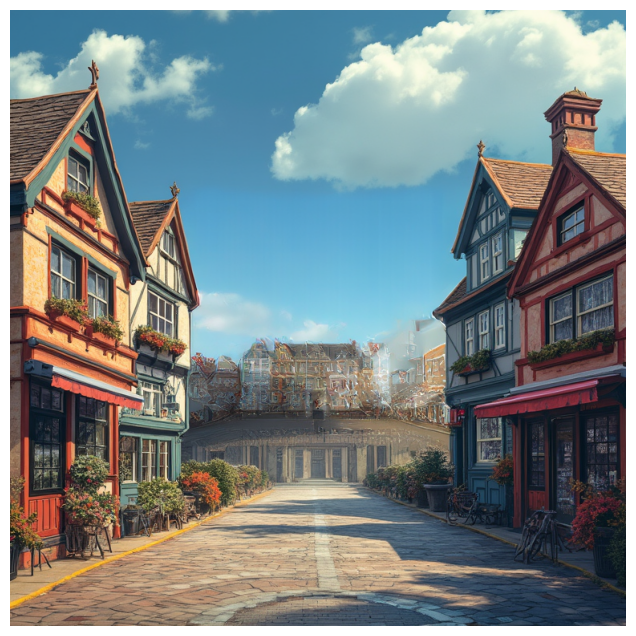

Projected 2731153 pixels from perspective to equirect with yaw=0, pitch=0
Projected 2731153 pixels from perspective to equirect with yaw=0, pitch=0


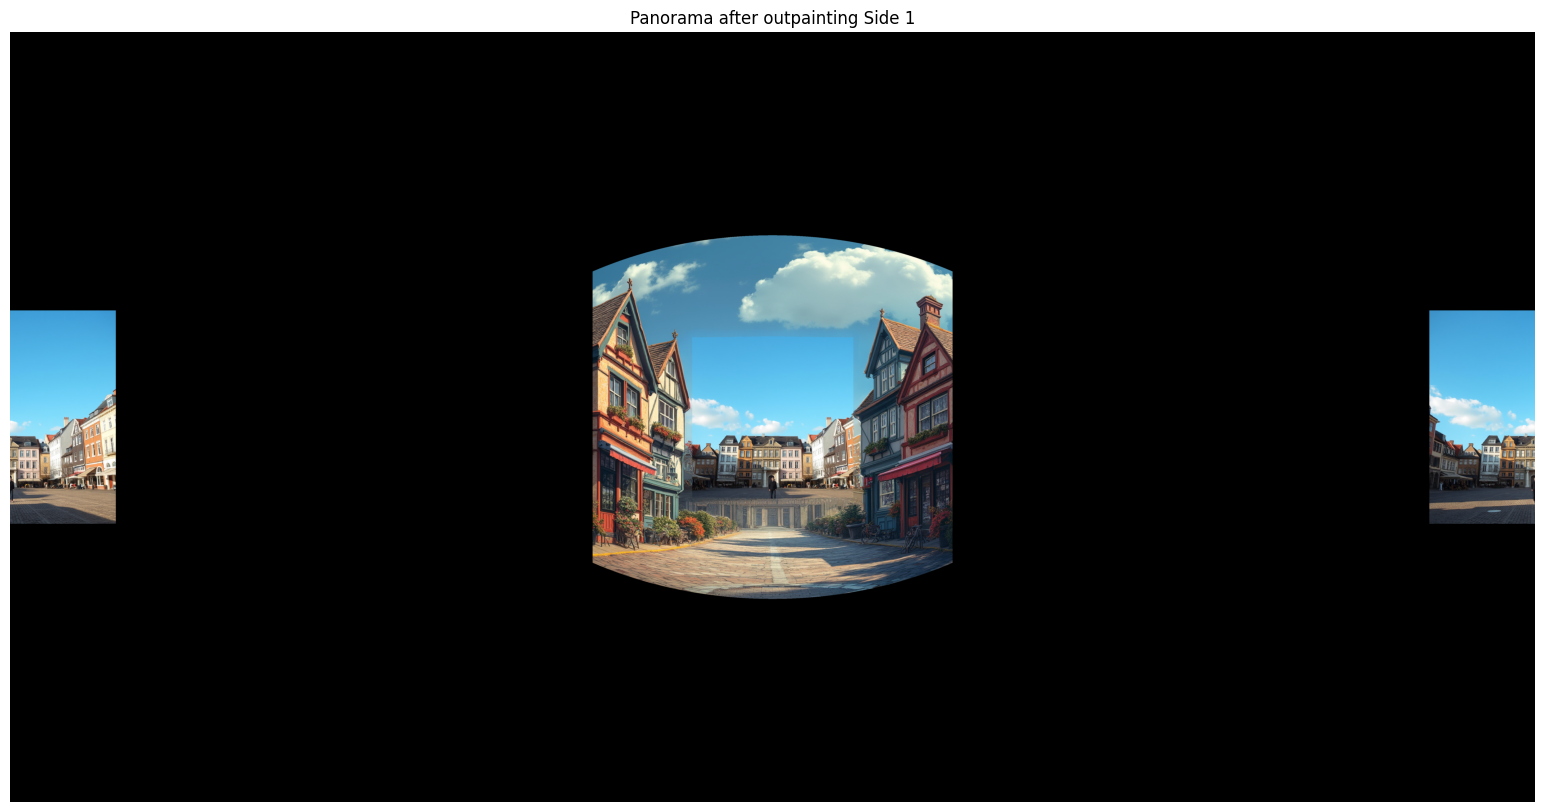

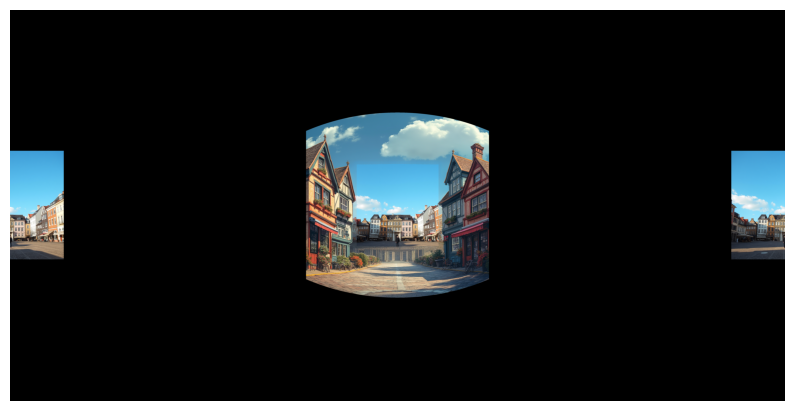

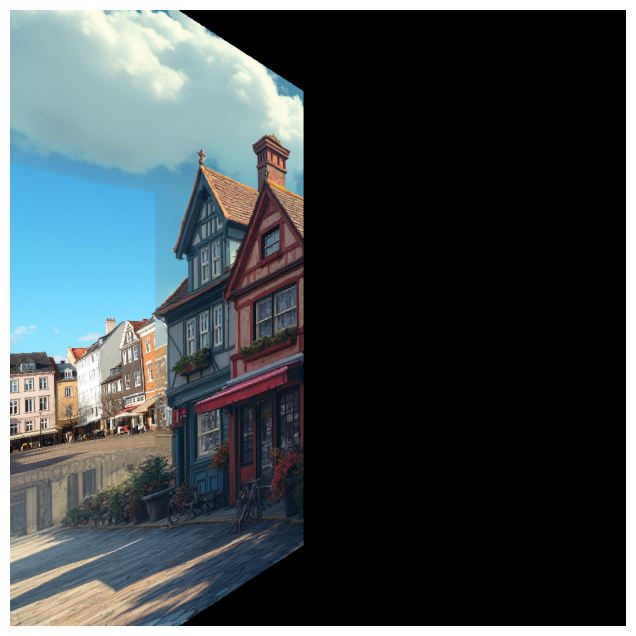

(1024, 1024)


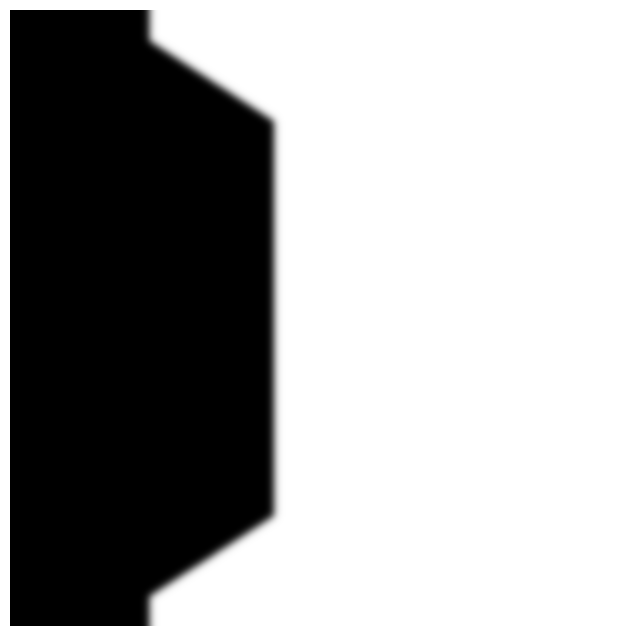

Render image shape: (1024, 1024)(1024, 1024)
Check inputs
Start denoise


  0%|          | 0/30 [00:00<?, ?it/s]

Inpainting done


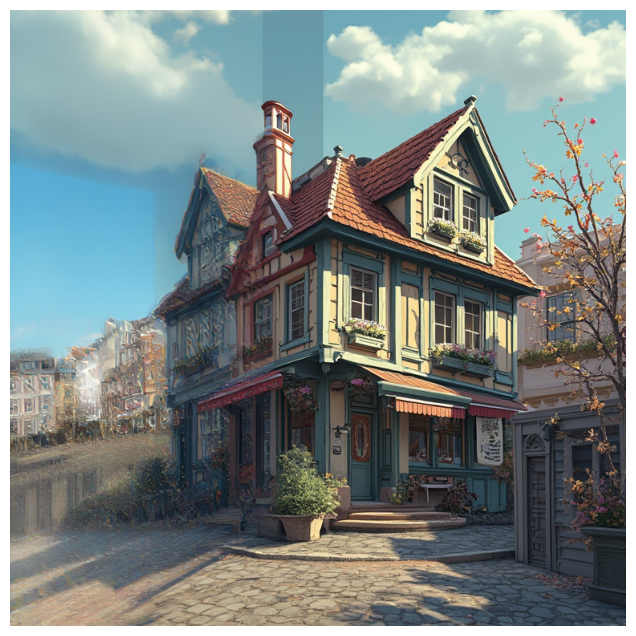

Projected 2290939 pixels from perspective to equirect with yaw=45, pitch=0
Projected 2290939 pixels from perspective to equirect with yaw=45, pitch=0


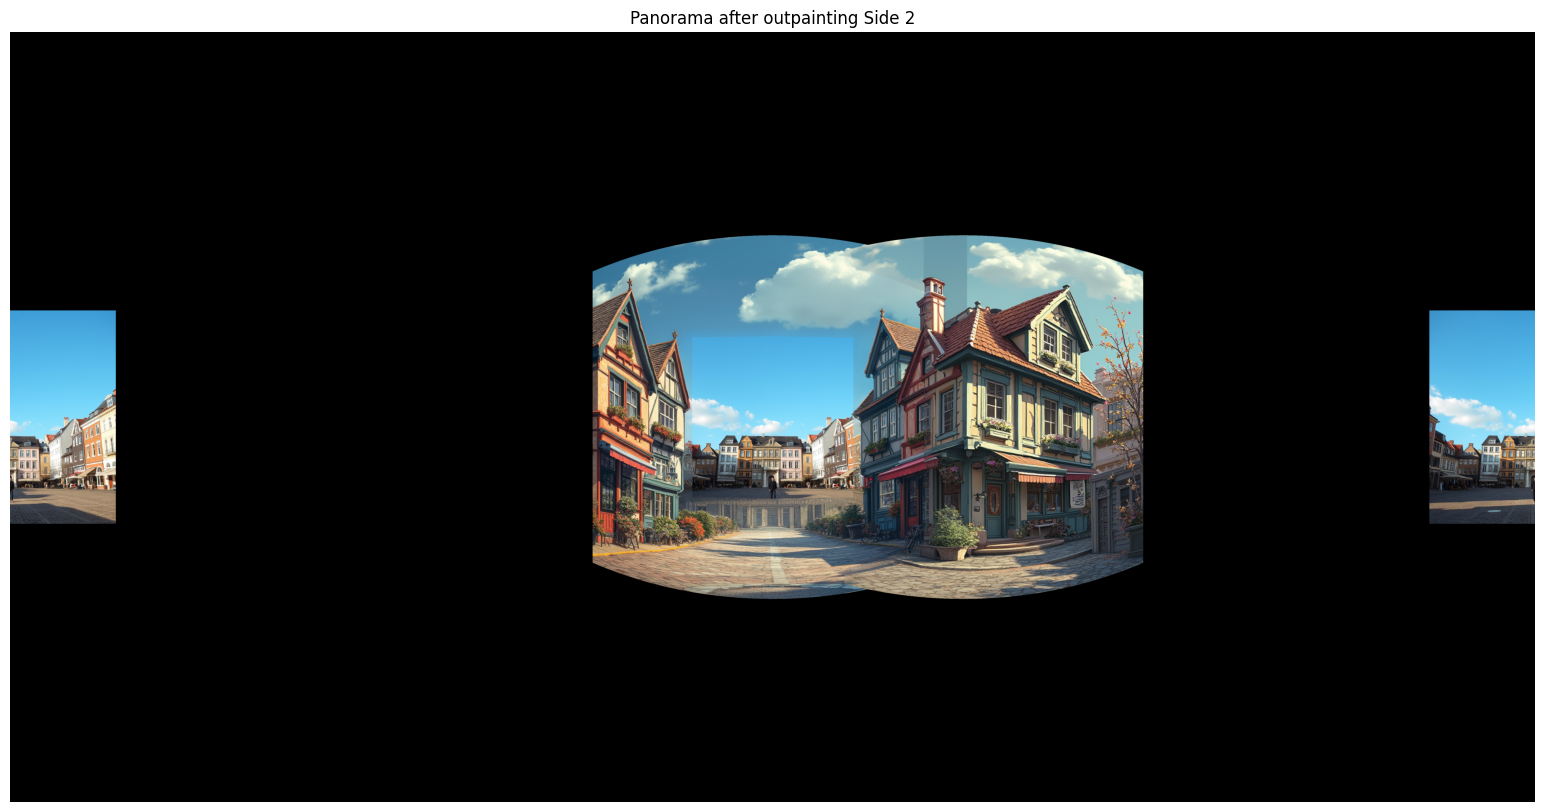

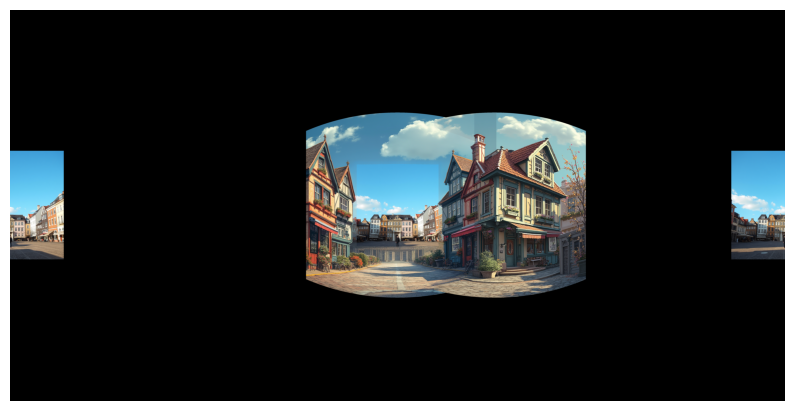

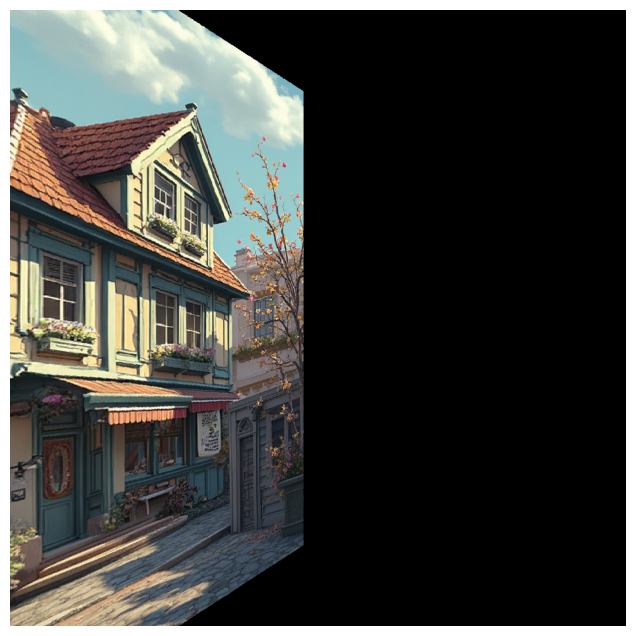

(1024, 1024)
(1024, 1024)


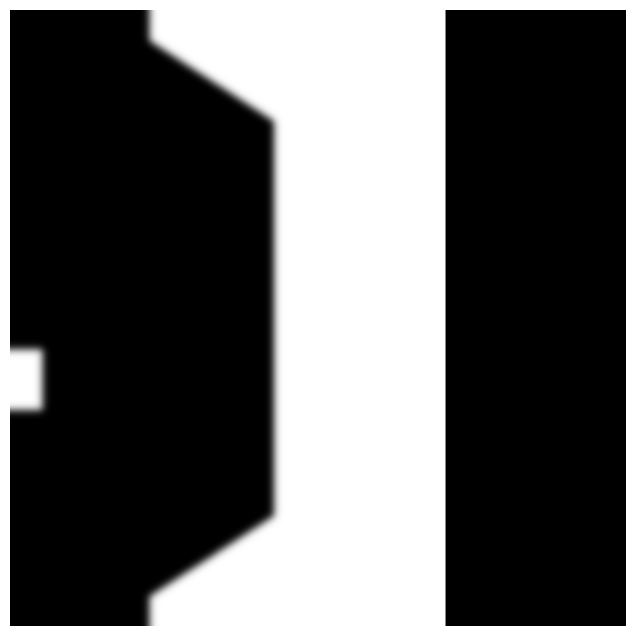

Check inputs
Start denoise


  0%|          | 0/30 [00:00<?, ?it/s]

Inpainting done


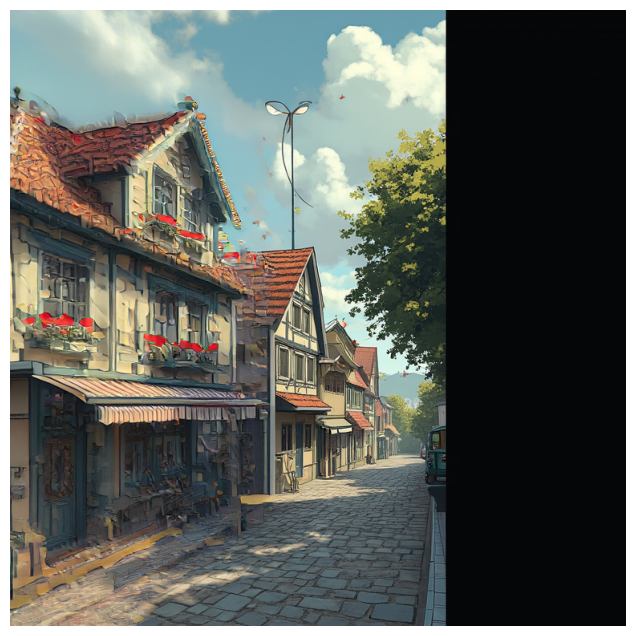

(1024, 1024)


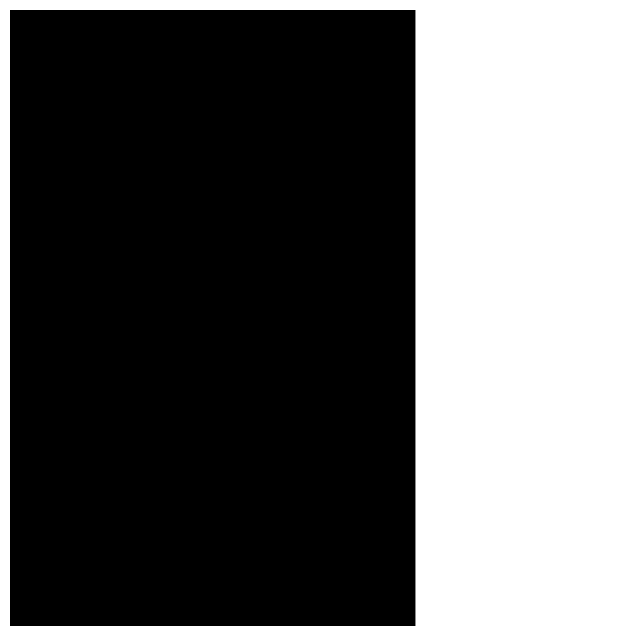

Render image shape: (768, 768)(1024, 1024)
Check inputs
Start denoise


  0%|          | 0/30 [00:00<?, ?it/s]

Inpainting done


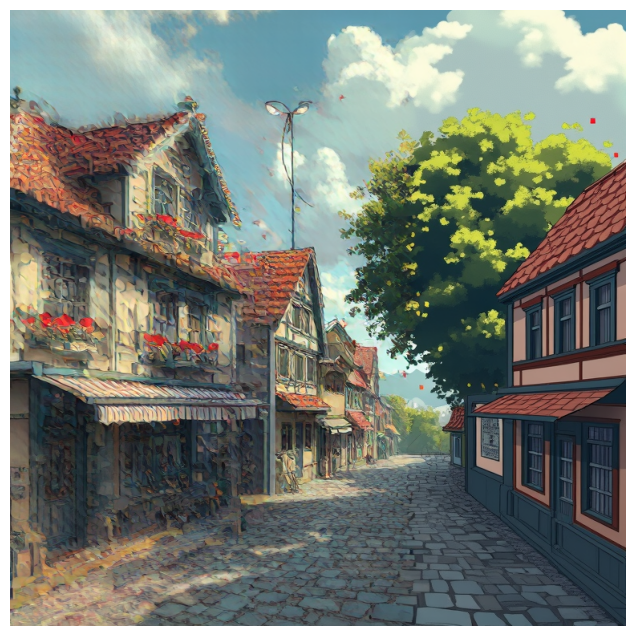

Projected 2313189 pixels from perspective to equirect with yaw=90, pitch=0
Projected 2313189 pixels from perspective to equirect with yaw=90, pitch=0


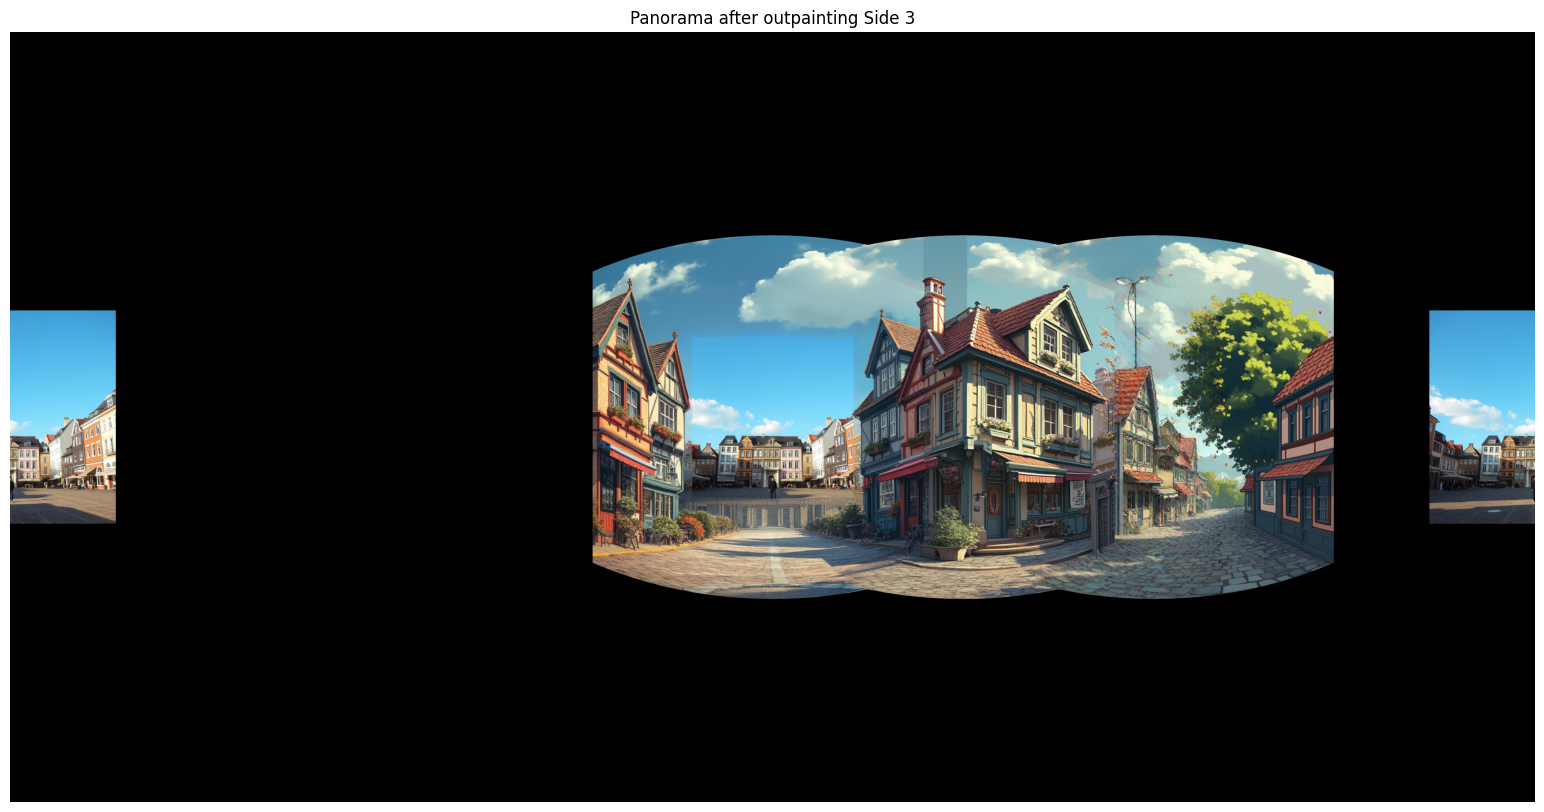

'\nfor idx,view in enumerate(side_views) : \n    mask = view[\'mask\']\n    mask[mask==255] = 1\n    #mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))\n    render_img = cv2.cvtColor(view[\'render\'], cv2.COLOR_BGR2RGB)\n    show_image_cv2(render_img)\n    render_img = cv2_to_pil(render_img)\n    \n    print(f"Render image shape: {render_img.size}{mask.shape}")\n    image = generate_outpaint(pipeline, render_img, mask,vis=True)\n    if idx == 1 : \n    \tbreak\n'

In [7]:
top_and_bottom_views = [all_views_data[0],all_views_data[3]]
side_views = all_views_data[6:]
clear_gpu_memory()

USE_CONTROLNET = True
if USE_CONTROLNET:
	pipeline = load_contolnet_pipeline()
else:
	pipeline = load_pipeline()
 
'''
for view in top_and_bottom_views[:2] :
    mask = view['mask']
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    #show_image_cv2(new_mask)
    inital_pano = Image.open("initial_pano_with_back.png")
    initial_pano_np = np.array(inital_pano)
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)

    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt='floor of a city town square')
    final_pano = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=-view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=mask  # Original mask - only project where we outpainted
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(final_pano)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''


inital_pano = Image.open("imgs/initial_pano_with_back.png")
initial_pano_np = np.array(inital_pano)
output_size = 1024
'''
for view in top_and_bottom_views :
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                initial_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    
    mask = create_mask_from_black(render_img, threshold=10)
    
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    
    render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    if view['label'] == 'Top' : 
        prompt = 'Floor of a city town square'      
    else : 
        prompt = 'Sky of a city town square, no buildings'
    
    
	
    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt=prompt)
    image.save("outpainted_test.png")
    #image = Image.open("outpainted_test.png")
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=None,  # Original mask - only project where we outpainted
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''
side_view_pano = Image.open("imgs/initial_pano_center.png")
side_view_pano_np = np.array(side_view_pano)
for idx,view in enumerate(side_views[:3]):
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                side_view_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    show_image_cv2(cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB))
    
    mask = create_mask_from_black(render_img, threshold=10)
    if idx == 2 : 
        cp_mask = fix_inpaint_mask(copy.deepcopy(mask),extend_amount=100)
        new_mask = fix_inpaint_mask(mask,extend_amount=100,add_boarder_mode='r1')
        
        new_mask = Image.fromarray(new_mask).convert("L")
        render_img = Image.fromarray(render_img).convert("RGB")
        show_image_cv2(pil_to_cv2(new_mask))
        
        prompt = 'a different house on a market square'      
        
        render_img = outpaint_controlnet(pipeline, render_img, new_mask,vis=True,prompt=prompt,num_steps=30,guidance_scale=3.5,cond_scale=0.4)
        new_mask = fix_inpaint_mask(mask,extend_amount=100,add_boarder_mode='r2')
        new_mask = Image.fromarray(new_mask).convert("L")
        show_image_cv2(pil_to_cv2(new_mask))
        
        prompt = 'a different house on a market square'      
        
        print(f"Render image shape: {render_img.size}{mask.shape}")
        #image = Image.open('top1.png')
        image = outpaint_controlnet(pipeline, render_img, new_mask,vis=True,prompt=prompt,num_steps=30,guidance_scale=3.5,cond_scale=0.4)
        new_mask = cp_mask
    else : 
        new_mask = fix_inpaint_mask(mask,extend_amount=100)
        new_mask = Image.fromarray(new_mask).convert("L")
        new_mask.save("new_mask.png")
        render_img = Image.fromarray(render_img).convert("RGB")
        render_img.save("render_img.png")
        
        show_image_cv2(pil_to_cv2(new_mask))
        
        prompt = 'a different house on a market square'      
        
        print(f"Render image shape: {render_img.size}{mask.shape}")
        #image = Image.open('top1.png')
        image = outpaint_controlnet(pipeline, render_img, new_mask,vis=True,prompt=prompt,num_steps=30,guidance_scale=3.5,cond_scale=0.4)
    image.save("outpainted_test.png")
    image = image.resize((1024, 1024), Image.LANCZOS)
    
    new_mask = np.array(new_mask)
    #image = generate_outpaint(pipeline, image, np.ones_like(new_mask),vis=True,num_steps=20,prompt=prompt)
    #image = Image.open("outpainted_test.png")
    cur_mask = new_mask 
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=cur_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )
    
    side_view_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        side_view_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=cur_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()

'''
for idx,view in enumerate(side_views) : 
    mask = view['mask']
    mask[mask==255] = 1
    #mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    
    print(f"Render image shape: {render_img.size}{mask.shape}")
    image = generate_outpaint(pipeline, render_img, mask,vis=True)
    if idx == 1 : 
    	break
'''